## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import time
from os.path import exists

from models.neuralnetwork.spherical_cnn import SCNNModel
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical, scale_to_range
from sphericalharmonics.spherical_fourier_transform import get_spherical_fourier_transform
from sphericalharmonics.spherical_fourier_transform import get_design_matrix
from sphericalharmonics.spherical_fourier_transform import get_inverse_spherical_fourier_transform
from utils.logging import print_training_progress
from visualization.spherical_functions_visualisation import get_spherical_function_values_from_spherical_expansion
from lossfunctions.cross_correlation import CrossCorrelationLoss

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

from models.neuralnetwork.fully_connected import FullyConnected4Layers
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from sphericalharmonics.spherical_fourier_transform import get_spherical_fourier_transform
from sphericalharmonics.spherical_fourier_transform import get_design_matrix
from lossfunctions.cross_correlation import CrossCorrelationLoss
from utils.logging import print_training_progress

from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd

from models.sphericaldeconvolution.spherical_deconvolution import spherical_deconvolution_fit
from models.sphericaldeconvolution.fibre_response_function import simple_fibre_response_function, diffusion_tensor_response_function
from dataloader.load_dt_simulated import load_dt_simulated_multiple_populations
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from visualization.spherical_functions_visualisation import get_spherical_function_values_from_spherical_expansion
from sphericalharmonics.spherical_fourier_transform import get_spherical_harmonics_expansion_coefficients

# Spherical convolutional neural network for fODF estimation

## Hyperparameters

In [2]:
number_of_shells = 1
output_size = 45
learning_rate = 0.001
learning_rate_decay = 0.1
batch_size = 1000
num_batches = 40000
num_batches_lr_reduction = [15000,20000,35000]
max_degree = 8


save_trained_model_path = './savedmodels/scnn/model_weights.pth'

## Load dataset

In [3]:
all_dwis = np.load('./data2/planar/no_rotation/diffusion_weighted_signals.npy')
all_fODFs = np.load('./data2/planar/no_rotation/fODF_sh_coefficients.npy')
all_qhat = np.load('./data2/planar/no_rotation/gradient_orientations.npy')
all_bvals = np.load('./data2/planar/no_rotation/b_values.npy')
all_dwis_sh_coefficients = np.load("./data2/planar/no_rotation/diffusion_weighted_signals_sh_coefficients.npy")

## Dataset plotting

In [4]:
plotting_index = 3

### Measurements

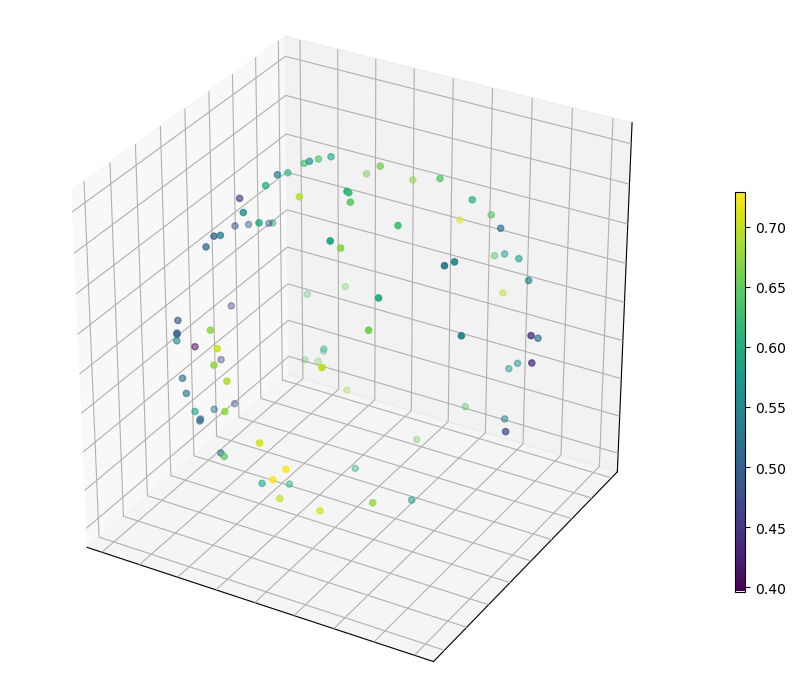

In [5]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection="3d")

# Remove ticks
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.xaxis.set_tick_params(color=(0, 0, 0, 0))
ax.yaxis.set_tick_params(color=(0, 0, 0, 0))
ax.zaxis.set_tick_params(color=(0, 0, 0, 0))

ax.scatter(all_qhat[plotting_index][0],all_qhat[plotting_index][1],all_qhat[plotting_index][2],c=all_dwis[plotting_index],vmin=np.min(all_dwis[plotting_index]),vmax=np.max(all_dwis[plotting_index]))
ax.set_aspect('equal')

# Add colorbar
cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(all_dwis[plotting_index]), vmax=np.max(all_dwis[plotting_index]))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

### Measurements (continuous)

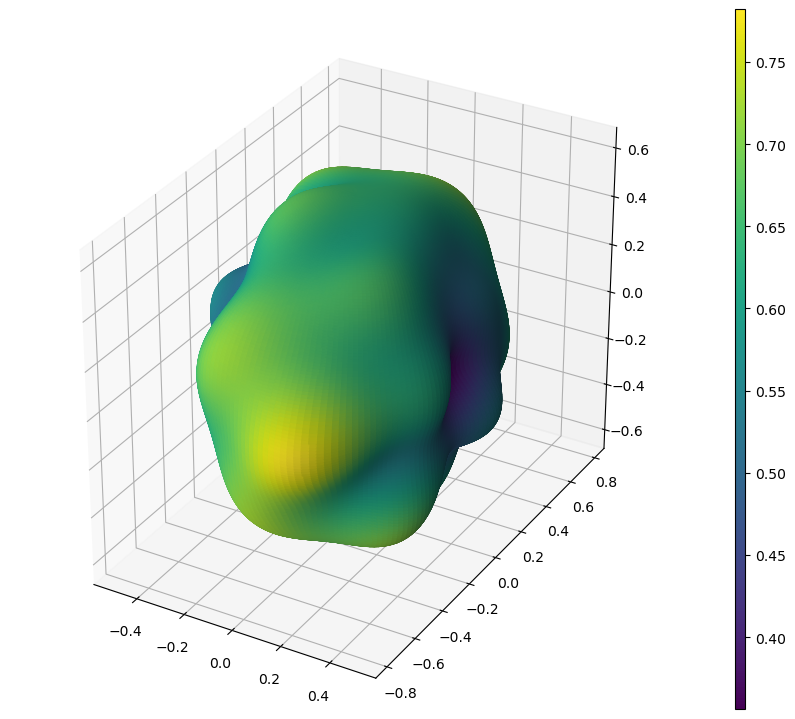

In [6]:
#%matplotlib qt

x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(all_dwis_sh_coefficients[plotting_index],max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cmap(normalization(fcolors)), shade=True)
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

### Measurement expansion coefficients

In [7]:
all_dwis_sh_coefficients[plotting_index]

array([ 2.12503404e+00, -4.87831864e-02, -2.40181861e-03,  5.67915365e-02,
        1.37020938e-02, -2.68050876e-01, -1.38648360e-03,  1.16641253e-02,
       -2.25964395e-02, -1.65400861e-02,  3.78463006e-03,  6.18565437e-04,
       -4.41686418e-03,  6.45156837e-03, -9.15364790e-03,  1.25501355e-02,
       -1.13088128e-03, -2.51319562e-02, -1.56980415e-03,  4.45768430e-03,
        2.66347969e-02,  6.29979108e-03,  5.04873045e-03, -1.78993035e-02,
       -2.13437490e-02, -4.83515723e-03,  5.85246746e-03, -3.65726973e-02,
        2.53824403e-02,  1.96981211e-02,  3.50161885e-02,  3.32213177e-03,
        8.55939048e-03,  2.32499423e-02,  2.99077722e-02, -1.13594175e-02,
       -2.27157985e-03,  1.20426190e-02,  2.73592696e-02,  4.94869704e-03,
       -2.02528729e-02, -2.04789337e-02, -7.75120662e-03,  1.44221136e-03,
       -2.61918424e-02])

### fODFs

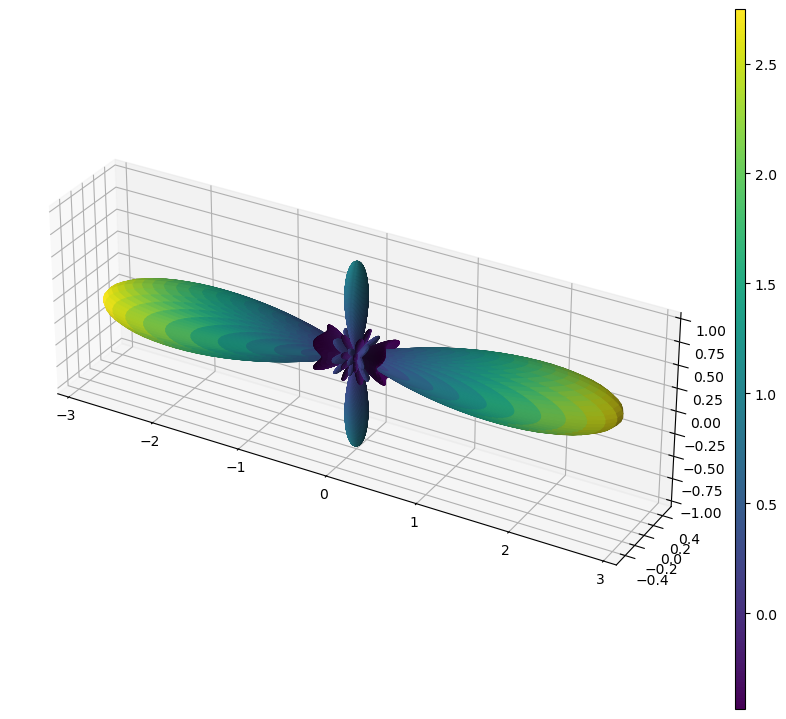

In [8]:
x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(all_fODFs[plotting_index],max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cmap(normalization(fcolors)), shade=True)
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

### fODFs expansion coefficients

In [9]:
all_fODFs[plotting_index]

array([ 2.82094792e-01,  7.59039142e-02,  0.00000000e+00, -8.48806306e-02,
        0.00000000e+00,  4.05981643e-01,  1.70746459e-01,  0.00000000e+00,
       -6.57347180e-02, -1.50792979e-18,  4.46216171e-01, -9.65599836e-18,
       -3.51590416e-01,  0.00000000e+00,  4.40653189e-01,  2.71069788e-01,
        0.00000000e+00, -1.37660196e-01, -5.32831986e-18,  6.39999867e-02,
        2.97466521e-18,  7.38073826e-03,  1.90482093e-17,  3.42311987e-01,
       -1.06841022e-17, -3.55265959e-01,  0.00000000e+00,  4.37659789e-01,
        3.69056186e-01,  0.00000000e+00, -2.11215877e-01, -1.00418979e-17,
        1.30526147e-01,  9.97920066e-18, -6.33816148e-02, -4.43208406e-18,
        5.23916280e-01, -2.83807619e-17, -3.39004548e-01,  2.00098347e-17,
        3.36854794e-01, -1.04737269e-17, -3.41021760e-01,  0.00000000e+00,
        4.04645467e-01])

## Pre-processing

The data is pre-processed as usual and the diffusion weighted signals are transformed to SH expansion coefficients. These coefficients are then used as the network input and the network output is the fODF coefficients.

In [10]:
thetas, phis = convert_coords_from_cartesian_to_spherical(all_qhat[0])

## Compute spherical Fourier transform

In [11]:
design_matrix = get_design_matrix(max_degree = max_degree ,number_of_samples=len(all_bvals[0]), thetas=thetas, phis=phis)
spherical_fourier_transform = get_spherical_fourier_transform(design_matrix)

## Compute inverse spherical Fourier transform

In [12]:
inverse_spherical_fourier_transform = get_inverse_spherical_fourier_transform(design_matrix)

## Convert numpy arrays to tensors

In [13]:
spherical_fourier_transform = torch.from_numpy(spherical_fourier_transform).float()
inverse_spherical_fourier_transform = torch.from_numpy(inverse_spherical_fourier_transform).float()

## Define model

In [14]:
model = SCNNModel(number_of_shells, number_of_shells, max_degree, spherical_fourier_transform, inverse_spherical_fourier_transform)

number_of_all_parameters = sum(p.numel() for p in model.parameters())
number_of_trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Number of all parameters: {number_of_all_parameters}')
print(f'Number of trainable parameters: {number_of_trainable_parameters}')

[output_channels, input_channels, sh_coefficients]: torch.Size([16, 1, 5])
[output_channels, input_channels, sh_coefficients]: torch.Size([32, 16, 5])
[output_channels, input_channels, sh_coefficients]: torch.Size([64, 32, 5])
[output_channels, input_channels, sh_coefficients]: torch.Size([128, 64, 5])
[output_channels, input_channels, sh_coefficients]: torch.Size([64, 128, 5])
[output_channels, input_channels, sh_coefficients]: torch.Size([32, 128, 5])
[output_channels, input_channels, sh_coefficients]: torch.Size([16, 64, 5])
[output_channels, input_channels, sh_coefficients]: torch.Size([16, 32, 5])
[output_channels, input_channels, sh_coefficients]: torch.Size([1, 16, 5])
Number of all parameters: 123040
Number of trainable parameters: 123040


## Train the S-CNN

In [15]:
all_dwis_sh_coefficients = np.expand_dims(all_dwis_sh_coefficients,1)

criterion = CrossCorrelationLoss(max_degree)
#criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=learning_rate_decay)

# Data arrays
train_data = all_dwis_sh_coefficients[:60000]
train_targets = all_fODFs[:60000]
val_data = all_dwis_sh_coefficients[60000:65000]
val_targets = all_fODFs[60000:65000]
test_data = all_dwis_sh_coefficients[80000:]
test_targets = all_fODFs[80000:]

# Lists to store errors for plotting
train_errors = []
val_errors = []

# Move model to GPU
device = torch.device('mps')
model.to(device)

# Training start timestamp
start_time = time.time()

# Best validation error to select the best model
best_validation_error = None

# Training loop
for batch in range(num_batches):
    
    # Adjust learning rate
    if batch in num_batches_lr_reduction:
        scheduler.step()

    indices = torch.randperm(len(train_data))[:batch_size]

    inputs = torch.FloatTensor(train_data[indices])
    targets = torch.FloatTensor(train_targets[indices])
    
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_errors.append(loss.item())

    # Calculate validation errors
    with torch.no_grad():
        val_inputs = torch.FloatTensor(val_data).to(device)
        val_target = torch.FloatTensor(val_targets).to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_target)
        val_errors.append(val_loss.item())
        
        current_validation_error = val_loss.item()
        
        if (best_validation_error is None) or (current_validation_error < best_validation_error):
            pass
            torch.save(model.state_dict(), save_trained_model_path)
        
        if(batch % 10 == 0):
            pass
            print_training_progress(batch, num_batches, loss.item(), val_loss.item(), start_time)

'Batch: 39990/40000'

'Training error: 0.28444981575012207, Validation error: 0.3677685856819153'

'Elapsed time: 18:12:21'

## Plot training and validation errors

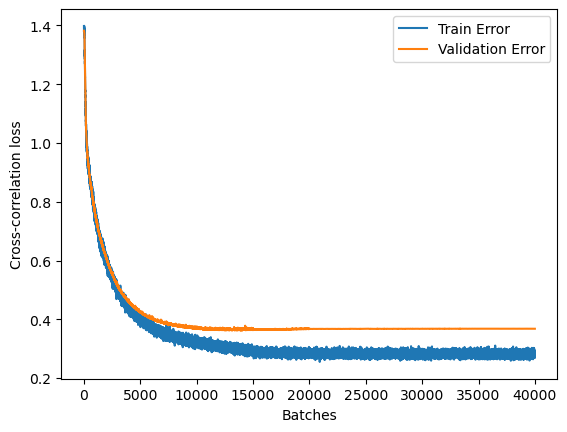

In [16]:
plt.plot(train_errors, label='Train Error')
plt.plot(val_errors, label='Validation Error')
plt.xlabel('Batches')
plt.ylabel('Cross-correlation loss')
plt.legend()
plt.show()

## Plot training and validation errors (detail)

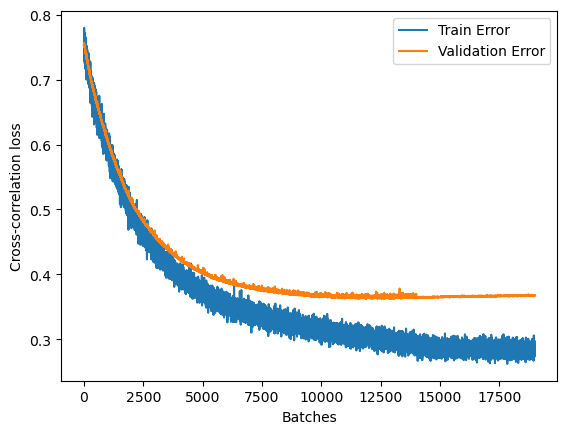

In [55]:
plt.plot(train_errors[1000:20000], label='Train Error')
plt.plot(val_errors[1000:20000], label='Validation Error')
plt.xlabel('Batches')
plt.ylabel('Cross-correlation loss')
plt.legend()
plt.show()

## Save plotting data

In [56]:
np.save("./plottingdata/u-net/train_errors", train_errors)
np.save("./plottingdata/u-net/val_errors", val_errors)

## Load model with lowest validation error

In [18]:
model.load_state_dict(torch.load(save_trained_model_path))
model.eval()

SCNNModel(
  (encoder1): SphericalConvolution()
  (encoder2): SphericalConvolution()
  (encoder3): SphericalConvolution()
  (encoder4): SphericalConvolution()
  (decoder1): SphericalConvolution()
  (decoder2): SphericalConvolution()
  (decoder3): SphericalConvolution()
  (decoder4): SphericalConvolution()
  (decoder5): SphericalConvolution()
)

## Compute best error on the validation set

In [19]:
val_outputs = model(torch.FloatTensor(val_data).to('mps'))

In [20]:
criterion(val_outputs, val_target).item()

0.367757648229599

## Compute error on the test set

In [21]:
test_outputs = model(torch.FloatTensor(test_data[:1000]).to('mps'))

In [22]:
criterion(test_outputs, torch.FloatTensor(test_targets[:1000]).to('mps')).item()

0.3513338267803192

## Plot predicted fODF from test set

In [23]:
test_outputs = test_outputs.cpu().detach().numpy()

### Prediction

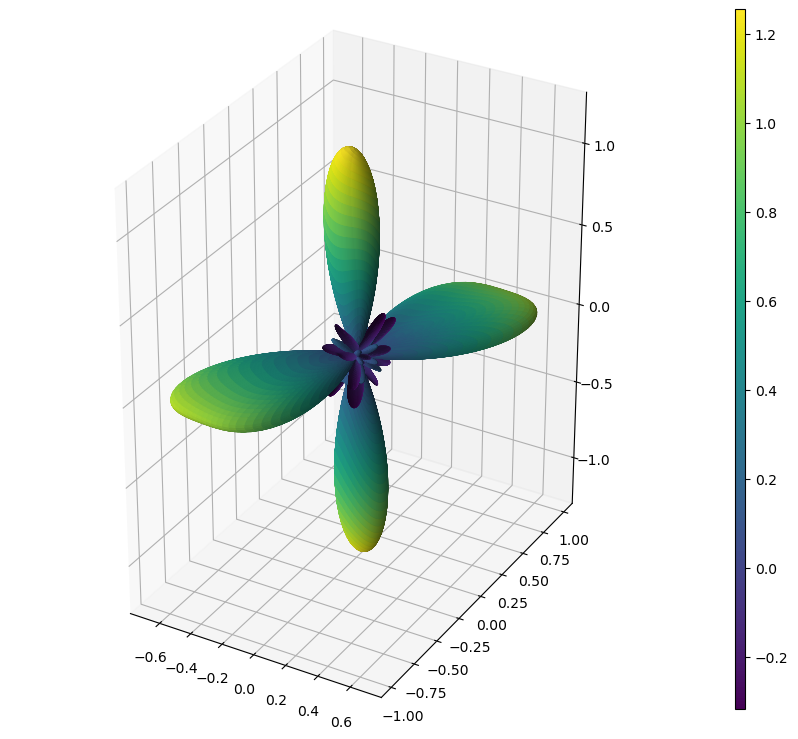

In [24]:
x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(test_outputs[1], max_degree=max_degree,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(normalization(fcolors)), shade=True)
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

### Ground truth

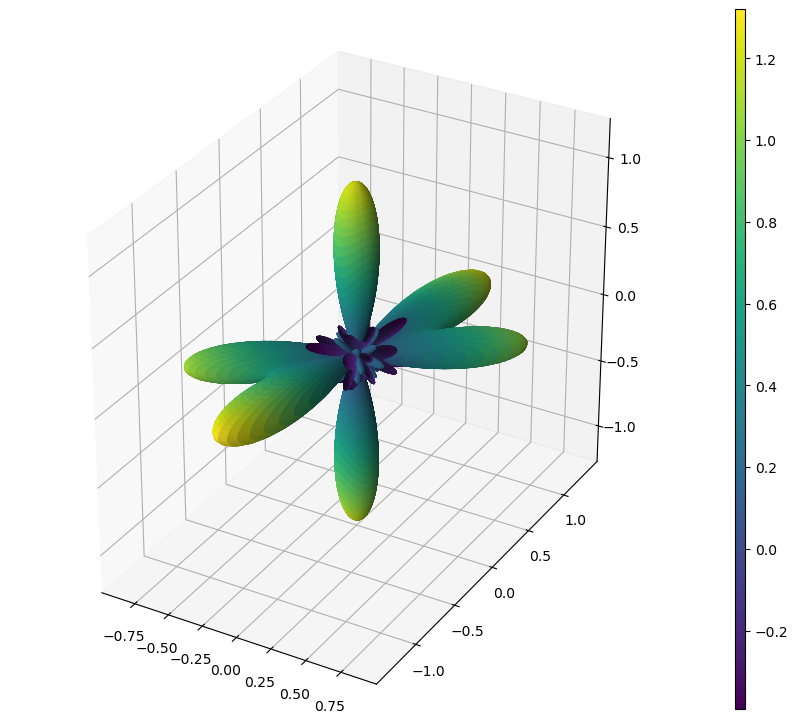

In [25]:
x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(test_targets[1], max_degree=max_degree,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(normalization(fcolors)), shade=True)
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

## Load data with rotations

In [28]:
all_rotated_dwis = np.load('./data2/planar/rotation/diffusion_weighted_signals.npy')
all_rotated_fODFs = np.load('./data2/planar/rotation/fODF_sh_coefficients.npy')[:5000]
all_rotated_qhat = np.load('./data2/planar/rotation/gradient_orientations.npy')
all_rotated_bvals = np.load('./data2/planar/rotation/b_values.npy')
all_rotated_dwis_sh_coefficients = np.load("./data2/planar/rotation/diffusion_weighted_signals_sh_coefficients.npy")[:5000]
all_rotated_dwis_sh_coefficients = np.expand_dims(all_rotated_dwis_sh_coefficients,1)

## Compute error on rotated data

In [29]:
rotated_inputs = torch.FloatTensor(all_rotated_dwis_sh_coefficients).to(device)
rotated_target = torch.FloatTensor(all_rotated_fODFs).to(device)
rotated_outputs = model(rotated_inputs)
rotated_loss = criterion(rotated_outputs, rotated_target)
rotated_loss.item()

1.521557331085205

## Plot predited fODF on rotated data

In [30]:
rotated_outputs = rotated_outputs.cpu().detach().numpy()

In [45]:
all_rotated_dwis_sh_coefficients.shape

(5000, 1, 45)

### Prediction

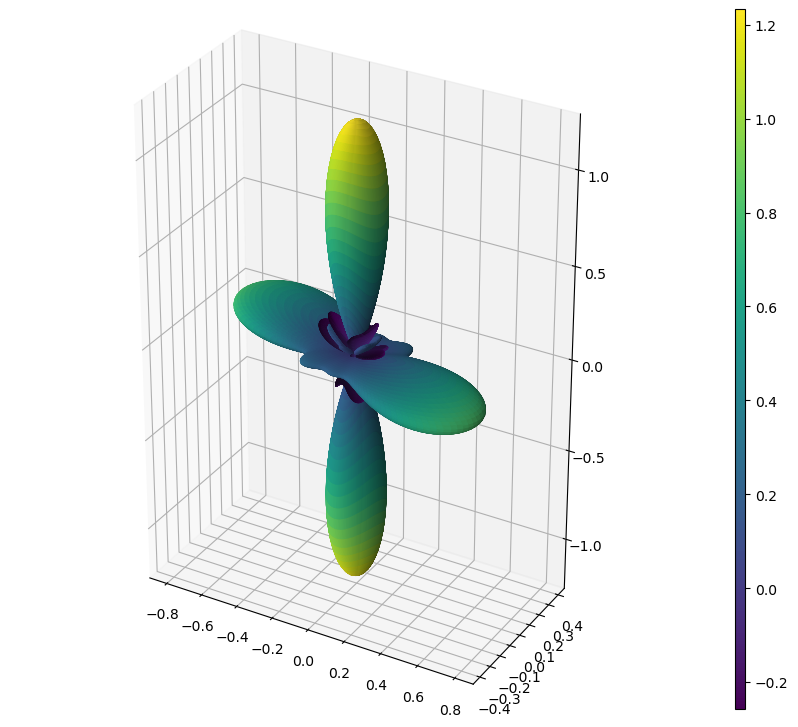

In [51]:
x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(rotated_outputs[6], max_degree=max_degree,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(normalization(fcolors)), shade=True)
plt.gca().set_aspect('equal')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

### Ground truth

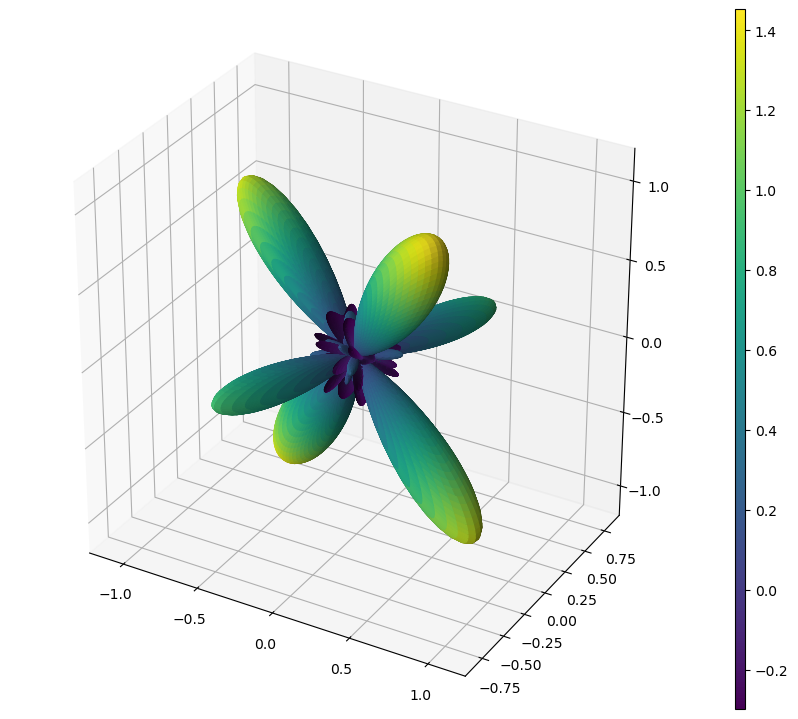

In [52]:
x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(all_rotated_fODFs[6], max_degree=max_degree,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(normalization(fcolors)), shade=True)
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()